In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
from scipy.optimize import minimize

In [43]:
# generate n random data from gamma mixture model
def generate_gamma_mixture(n, weights, a_params, b_params):
    """
    Generate n random samples from a gamma mixture model.

    Parameters:
    n (int): Number of samples to generate.
    weights (list): List of weights for each gamma component.
    a_params (list): List of 'a' parameters for each gamma component.
    b_params (list): List of 'b' parameters for each gamma component.

    Returns:
    np.ndarray: Array of generated samples.
    """
    # Normalize weights
    weights = np.array(weights)
    weights /= weights.sum()

    # Choose components based on weights
    components = np.random.choice(len(weights), size=n, p=weights)
    # print(components.sum())
    # Generate samples
    samples = np.array([gamma.rvs(a_params[i], scale=b_params[i]) for i in components])

    return samples


def gamma_mixture_likelihood(params, n_components, samples):
    """
    Calculate the negative log-likelihood of the gamma mixture model.
    
    Parameters:
    params (list): List of parameters to optimize (weights, a_params, b_params).
    n_components (int): Number of components in the mixture model.
    samples (np.ndarray): Array of observed samples.

    Returns:
    float: Negative log-likelihood value.
    """
    likelihood = np.zeros_like(samples)

    for i in range(n_components):
        likelihood += params[i] * gamma.pdf(samples, params[n_components + i], scale=params[2 * n_components + i])

    # Avoid log(0) by adding a small constant
    likelihood = np.clip(likelihood, 1e-10, None)
    return -np.sum(np.log(likelihood))
def estimate_gamma_mixture(samples, n_components):
    """ Estimate the parameters of a gamma mixture model.
    Parameters:
    samples (np.ndarray): Array of observed samples.
    n_components (int): Number of components in the mixture model.
    Returns:
    list: List of estimated parameters (weights, a_params, b_params).
    """
    # Initialize parameters
    weights = np.ones(n_components) / n_components
    a_params = np.ones(n_components)
    b_params = np.ones(n_components)

    # Optimize the parameters
    params0 = np.concatenate((weights, a_params, b_params))
    # Set bounds for weights (0,1) and a,b parameters (>0)    
    bounds = [(0, 1)] * n_components + [(1e-2, None)] * n_components + [(1e-2, None)] * n_components
    # add constraint that weights sum to 1
    const = {'type': 'eq', 'fun': lambda x: np.sum(x[:n_components]) - 1}
    # set options
    options = {'maxiter': 10000, 'disp': False, 'ftol': 1e-6}
    res = minimize(gamma_mixture_likelihood, params0, \
                   args=(n_components, samples), \
                    bounds=bounds, constraints=const, options=options)
    weights, a_params, b_params = res.x[:n_components], res.x[n_components:2*n_components], res.x[2*n_components:]

    return weights, a_params, b_params

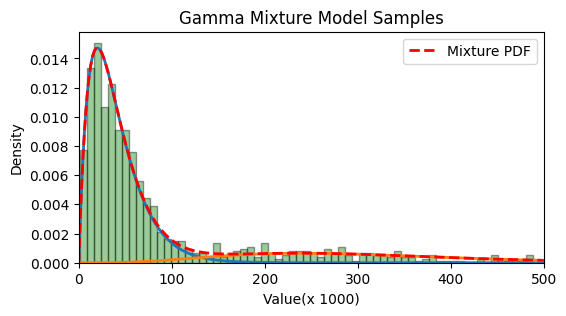

In [33]:
# Parameters for the gamma mixture model
weights = [0.8, 0.2]
a_params = [2, 5]#[2.5, 1.2]
b_params = [20, 60] #[10, 120

# Generate samples
n_samples = 1000
samples = generate_gamma_mixture(n_samples, weights, a_params, b_params)
# Plot histogram of the samples
fig = plt.figure(figsize=(6, 3))
plt.hist(samples, bins=100, density=True, alpha=0.4, \
         color='g', edgecolor='black')      
# Plot the individual beta components for reference
x = np.linspace(0, 500, 10000)
y = np.zeros_like(x)
for w, a, b in zip(weights, a_params, b_params):
    y += w * gamma.pdf(x, a, scale=b)
    plt.plot(x, w * gamma.pdf(x, a, scale=b), lw=2)
plt.plot(x, y, 'r--', lw=2, label='Mixture PDF')
plt.title('Gamma Mixture Model Samples')
plt.xlabel('Value(x 1000)')
plt.ylabel('Density')
plt.xlim(0, 500)
plt.legend()
plt.show()

In [48]:
# Parameters for the gamma mixture model
weights = [0.75, 0.25]
a_params = [2.5, 1.2]
b_params = [10, 120]

# Generate samples
n_samples = 1000
samples = generate_gamma_mixture(n_samples, weights, a_params, b_params)
# Estimate parameters from samples
est_weights, est_a_params, est_b_params = estimate_gamma_mixture(samples, n_components=2)
print("True Weights:", weights)
print("Estimated Weights:", est_weights)
print("True a Parameters:", a_params)
print("Estimated a Parameters:", est_a_params)
print("True b Parameters:", b_params)
print("Estimated b Parameters:", est_b_params)


True Weights: [0.75, 0.25]
Estimated Weights: [1. 0.]
True a Parameters: [2.5, 1.2]
Estimated a Parameters: [0.92287252 0.67745025]
True b Parameters: [10, 120]
Estimated b Parameters: [58.13915829 62.04330998]
